# 0. 데이터 정리

## 0 - 1. 필요 라이브러리 임포트

In [ ]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

In [ ]:
import torch 
import random

import torchvision
from torchvision import datasets 
from torchvision import transforms

import glob
import os
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import cv2

from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F


import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 0-2. GPU 셋팅

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Thu Apr 20 00:14:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:17:00.0 Off |                   On |
| N/A   34C    P0    63W / 300W |                  N/A |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

# 1. 데이터 불러오기

In [ ]:
filepath = glob.glob('dobae/open/train/*/*.png')

In [ ]:
df = pd.DataFrame(columns=['image', 'label'])
df['image'] = filepath
df['label'] = df['image'].str.split('/').str[-2]

In [ ]:
df.iloc[35], len(filepath)

(image    dobae/open/train/걸레받이수정/60.png
 label                            걸레받이수정
 Name: 35, dtype: object,
 3457)

In [ ]:
encoder = LabelEncoder()
encoder.fit(df['label'])
all_labels = encoder.transform(df['label'])
df['label_encode'] = all_labels
# encoding.inverse_transform #(encoding 한 코드 다시 원본으로 )

## 데이터셋 나누기 

In [ ]:
train_set, valid_set , _,_ = train_test_split(df,df['label_encode'],test_size=0.2, stratify=df['label_encode'],random_state=42)
# stratify : class 비율을 일정하게 만들어 준다. Target 값으로 넣어주면 그 값의 비율에 맞게 나누어 주기 때문에 꼭 필요!

## 전처리기 만들기 

In [ ]:
class MyData(Dataset):
    def __init__(self, image_filepath, label_filepath, transform=None):
        self.image_filepath = image_filepath
        self.label_filepath = label_filepath
        self.transform = transform

    def __len__(self):
        return len(self.image_filepath)

    def __getitem__(self,index):

        image = self.image_filepath[index]
        image = Image.open(image) # .convert('RGB')
        image = np.asarray(image) # 알버트 이미지 변환을 하기 위한 작업 

        if self.transform is not None: # 트랜스폼 처리가 존재하면 
            image = self.transform(image=image)['image']

        if self.label_filepath is not None: # 해당 데이터에 파일 패스가 존재하면 레이블도 함께 받아오기
            label = self.label_filepath[index]
            return image, label
        else:
            return image

In [ ]:
transform = A.Compose([A.Resize(300, 300), A.CLAHE(p=0.3),A.Normalize(), 
                       A.RandomRotate90(), A.HorizontalFlip(p=0.5), 
                       A.VerticalFlip(p=0.3), ToTensorV2()])
# 변환기

In [ ]:
trainset = MyData(train_set['image'].values, train_set['label_encode'].values,transform=transform)
validset = MyData(valid_set['image'].values, valid_set['label_encode'].values,transform=transform)

In [ ]:
len(trainset), len(validset)

(2765, 692)

In [ ]:
trainset[0]

# 2. 데이터 시각화

In [ ]:
# 한국어를 실행을 하지 못함
labels_map = {7 :'몰딩수정', 9:'석고수정', 18:'훼손', 17:'피스', 4:'녹오염', 0:'가구수정', 10:'오염', 5:'들뜸' , 2:'곰팡이',
 14:'창틀,문틀수정', 12:'울음', 11:'오타공', 8:'반점', 6:'면불량', 15:'터짐', 16:'틈새과다' , 1:'걸레받이수정'
 ,13:'이음부불량', 3:'꼬임'}

In [ ]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, 32)
    result = imageset[rand_i]
    image, label = result[0], result[1]
    axes[i].axis('off')
    axes[i].imshow(image.permute(1,2,0))
    axes[i].set_title(labels_map[label])
    plt.show

# 3. 데이터 적재 

In [ ]:
batch_size = 8
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용 2765개 데이터
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용 692개 데이터

In [ ]:
print(type(trainloader),len(trainloader))
print(type(validloader), len(validloader))

<class 'torch.utils.data.dataloader.DataLoader'> 346
<class 'torch.utils.data.dataloader.DataLoader'> 87


In [ ]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([8, 3, 300, 300]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


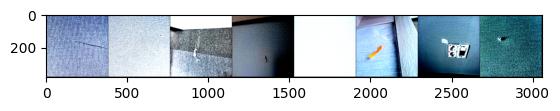

In [ ]:
grid_img = torchvision.utils.make_grid(images)
plt.imshow(grid_img.permute(1, 2, 0))

# 4. 모델 생성

In [ ]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=19)
model.to(device)

# 5. 모델 컴파일

```
batchsize = 8
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=19)
model.to(device)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)
```

In [ ]:
batchsize = 8
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [ ]:
out = model(images.to(device))
out.shape

torch.Size([8, 19])

In [ ]:
for parameter in model.parameters():
    print(parameter.requires_grad) # 수정 전

In [ ]:
# Freeze all the layers in the model
for name, param in model.named_parameters():
    param.requires_grad = False

# Unfreeze the final few layers for fine-tuning
for name, param in model.named_parameters():
    if '_fc' in name or '_conv_head' in name:
        param.requires_grad = True

In [ ]:
for parameter in model.parameters():
    print(parameter.requires_grad) # 수정 후

In [ ]:
# Print the number of trainable and frozen parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f'Number of trainable parameters: {num_trainable_params}')
print(f'Number of frozen parameters: {num_frozen_params}')

Number of trainable parameters: 17582683
Number of frozen parameters: 0


# 6. 모델 훈련 

In [ ]:
from collections import Counter

class_counts = Counter(all_labels)

total_samples = len(trainset)
num_classes = 19
class_weights = []
for i in range(num_classes):
    class_samples = class_counts[i]
    weight = total_samples / (num_classes * class_samples)
    class_weights.append(weight)

In [ ]:
class_weights

In [ ]:
from sklearn.metrics import f1_score

def validate(model, validloader, loss_fn):
    total = 0   
    valid_loss = 0
    preds = []
    true_labels = []

    # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)

            # 2. 전방향(Forward) 예측
            pred = model(images) # 예측 점수
            # _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            
            loss = loss_fn(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        weighted_f1_score = f1_score(true_labels, preds, average='weighted')
      
    return valid_loss, weighted_f1_score

In [ ]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = 1000000
    max_f1_score = 0
    trigger = 0
    patience = 7

    for epoch in range(epochs):
        model.train() # training mode
        train_loss = 0
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)

            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            if (steps % steps_per_epoch) == 0:
                model.eval() # evaluation mode
                valid_loss, weighted_f1_score = validate(model, validloader, loss_fn)
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                      'Weighted F1 Score : {:.3f}'.format(weighted_f1_score)            
                      )

                # Best model saving    
                if weighted_f1_score > max_f1_score:
                    max_f1_score = weighted_f1_score
                    best_model_state = deepcopy(model.state_dict())
                    torch.save(best_model_state, 'best_checkpoint.pth')

                # Early Stopping
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!') 
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss

                # Learning Rate Scheduler
                scheduler.step(loss)

    return

In [ ]:
epochs = 100
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/100....... Train Loss : 1.563 Valid Loss : 2.504 Weighted F1 Score : 0.513
Epoch : 2/100....... Train Loss : 1.253 Valid Loss : 1.357 Weighted F1 Score : 0.604
Epoch : 3/100....... Train Loss : 1.079 Valid Loss : 1.174 Weighted F1 Score : 0.690
Epoch : 4/100....... Train Loss : 0.993 Valid Loss : 1.349 Weighted F1 Score : 0.651
trigger :  1
Epoch : 5/100....... Train Loss : 0.900 Valid Loss : 1.005 Weighted F1 Score : 0.681
Epoch : 6/100....... Train Loss : 0.830 Valid Loss : 1.043 Weighted F1 Score : 0.717
trigger :  1
Epoch : 7/100....... Train Loss : 0.760 Valid Loss : 0.851 Weighted F1 Score : 0.740
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch : 8/100....... Train Loss : 0.555 Valid Loss : 0.673 Weighted F1 Score : 0.813
Epoch : 9/100....... Train Loss : 0.475 Valid Loss : 0.618 Weighted F1 Score : 0.827
Epoch : 10/100....... Train Loss : 0.401 Valid Loss : 0.636 Weighted F1 Score : 0.833
trigger :  1
Epoch : 11/100....... Train Loss : 0.391 Valid L

# 7. 모델 예측

In [ ]:
test_set = glob.glob('./dobae/open/test/*.png')
test_set.sort()
test_set

In [ ]:
testset = MyData(test_set, label_filepath= None,transform=transform)

In [ ]:
len(testset)

792

In [ ]:
testloader = DataLoader(testset,batch_size=8, shuffle=False)

test_iter = iter(testloader)
images = next(test_iter)

In [ ]:
test_set[0]

'./dobae/open/test/000.png'

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in testloader:
            imgs = images.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    
    return preds
preds = inference(model, testloader, device)

In [ ]:
len(preds)

792

In [ ]:
submit = pd.read_csv('dobae/open/sample_submission.csv')

In [ ]:
submit['label'] = preds
submit.head(3)

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18


In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [ ]:
submit.to_csv('./4_19_오후_EFB4_resize300_common.csv', index=False)

In [ ]:
# 결과
Epoch : 40/100....... Train Loss : 0.517 Valid Loss : 1.015 Valid Accuracy : 0.711
점수 : 0.421343637

# 8. 모델평가 및 모델 베스트 & 라스트 체크포인트 분석

In [ ]:
model.state_dict().keys()

## 라스트 모델

In [ ]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [ ]:
last_state_dict = torch.load('last_checkpoint.pth')

In [ ]:
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [ ]:
last_model.eval()
last_preds = inference(last_model, testloader, device)

In [ ]:
len(last_preds)

792

In [ ]:
submit = pd.read_csv('dobae/open/sample_submission.csv')
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [ ]:
submit['label'] = last_preds
submit

,id,label
0,TEST_000,18
1,TEST_001,10
2,TEST_002,18
3,TEST_003,7
4,TEST_004,10
...,...,...
787,TEST_787,18
788,TEST_788,10
789,TEST_789,10
790,TEST_790,10


In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,오염
...,...,...
787,TEST_787,훼손
788,TEST_788,오염
789,TEST_789,오염
790,TEST_790,오염


In [ ]:
submit.to_csv('./4_19_오후_EFB4_resize300_last.csv', index=False)

## 베스트 모델

In [ ]:
best_state_dict = torch.load('best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [ ]:
best_model.eval()
best_preds= inference(best_model, testloader, device)

In [ ]:
submit = pd.read_csv('dobae/open/sample_submission.csv')
submit

In [ ]:
submit['label'] = best_preds
submit

In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit

In [ ]:
submit.to_csv('./4_20_새벽_f1_resize300_best.csv', index=False)

# 9. 비교하기

In [ ]:
compare_df = pd.DataFrame(columns=['common_preds', 'last_preds', 'best_preds'])

In [ ]:
compare_df['common_preds'] = preds
compare_df['last_preds'] = last_preds
compare_df['best_preds'] = best_preds

In [ ]:
compare_df.to_csv('4_18_오후_compare_preds_Ver_resize300.csv', index=False)

In [ ]:
compare_df

In [ ]:
compare_df.count()

In [ ]:
compare_df['best_preds'].value_counts()

In [ ]:
compare_df['best_preds'].mode()

0    18
Name: best_preds, dtype: int64

In [ ]:
df1=compare_df.mode(axis=1)

In [ ]:
df1

,0,1,2
0,18.0,NaN,NaN
1,10.0,NaN,NaN
2,18.0,NaN,NaN
3,7.0,NaN,NaN
4,10.0,NaN,NaN
...,...,...,...
787,18.0,NaN,NaN
788,10.0,NaN,NaN
789,10.0,NaN,NaN
790,10.0,NaN,NaN
